## Evaluate WoFSCast Performance 

In [1]:
# From WoFSCast
import sys, os 
sys.path.insert(0, os.path.dirname(os.path.dirname(os.getcwd())))
from plot_params import target_vars, display_name_mapper, units_mapper

# Third-party
import xarray 
import numpy as np 
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import os

## Time Series of RMSE for the Target Variables (Full Domain : Solid, In Convection: Dashed) 

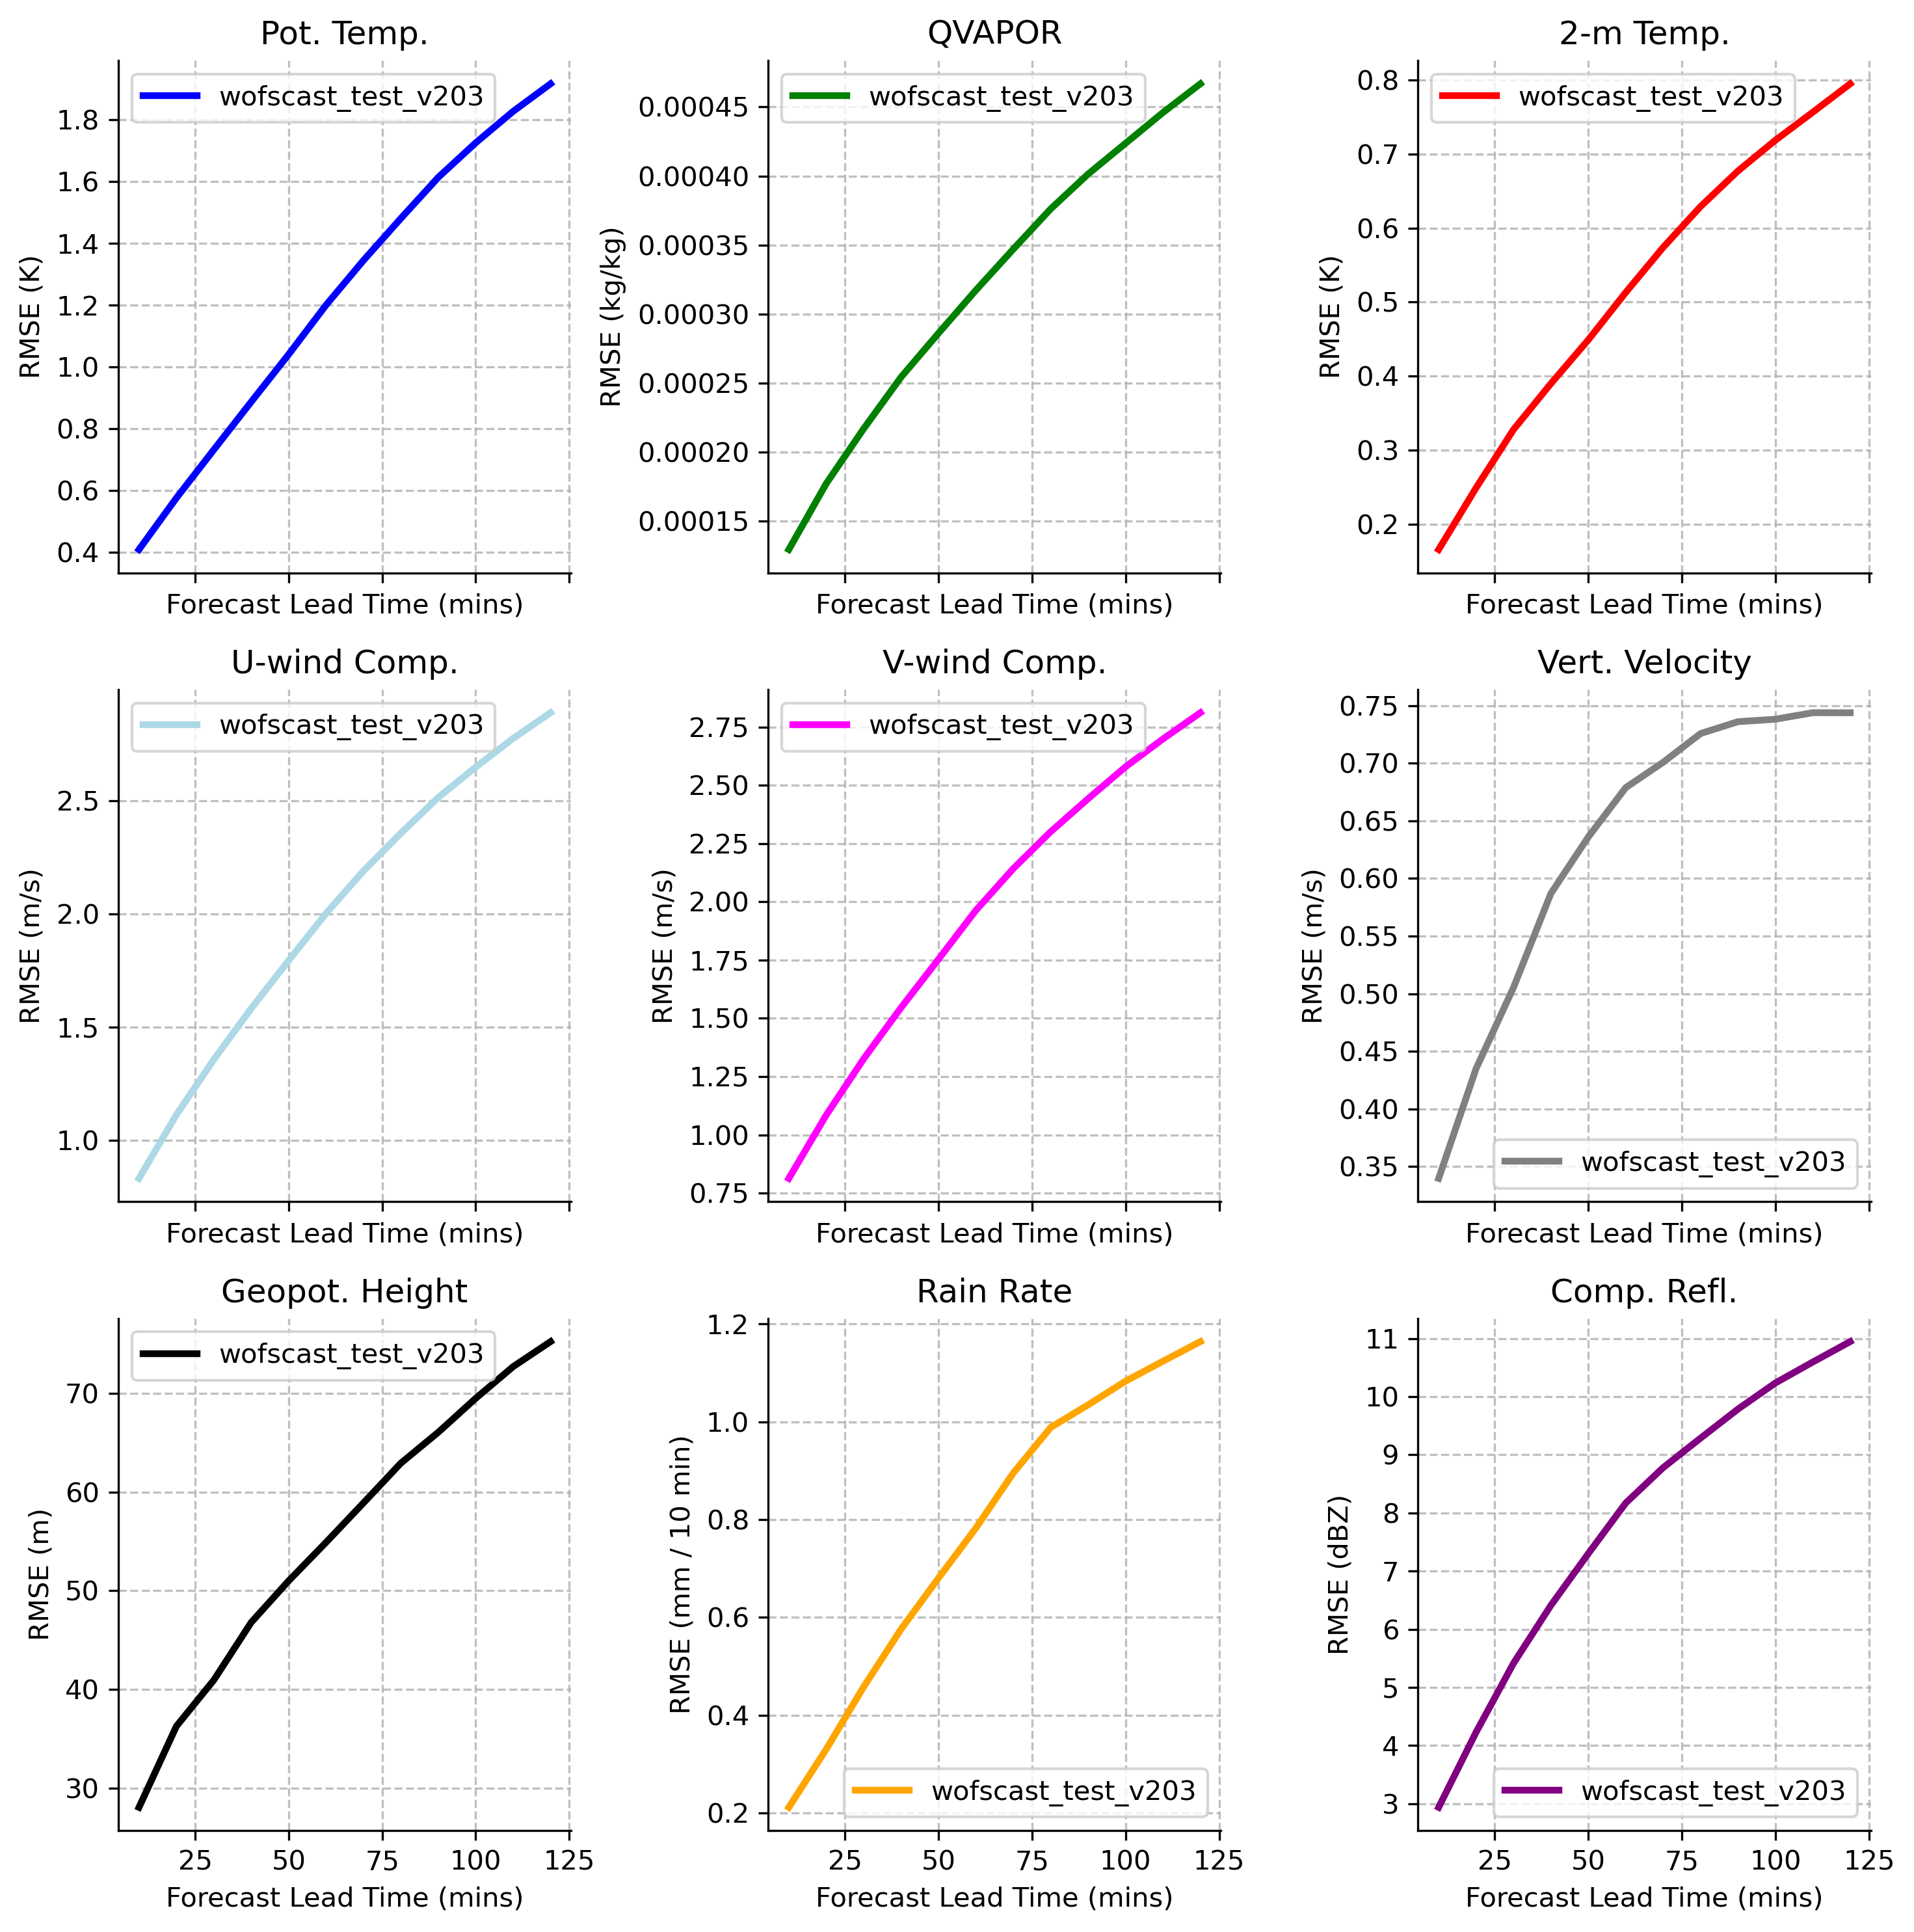

In [2]:
base_path = '/work/mflora/wofs-cast-data/verification_results'

models = [
          'wofscast_test_v203', 
          #'wofscast_10min_model_noise_v1_15min' 
         ]

display_name = {'wofscast_test_v178_diffusion' : 'WoFSCast w/Diff', 
                'wofscast_test_v178' : 'WoFSCast',
                'wofscast_test_v178_15min' : 'WoFSCast_178', 
                'wofscast_10min_model_noise_v1_15min' : 'WoFSCast_178_noise'
               }

variables = ['T', 'QVAPOR', 'T2', 
             'U', 'V', 'W',
             'GEOPOT', 'RAIN_AMOUNT', 'COMPOSITE_REFL_10CM'
            ]

rmse_dfs = [pd.read_parquet(os.path.join(base_path, f'MSE_{name}.parquet'), 
                            engine='pyarrow') for name in models]

# Get the time steps.

typ = 'Convective Regions'

times = rmse_dfs[0]['RMSE'][typ]['COMPOSITE_REFL_10CM'].index.total_seconds() / 60.0

fig, axes = plt.subplots(figsize=(10,10), dpi=300, ncols=3, nrows=3, sharex=True)

# Create a list of colors for each line
colors = ['blue', 'green', 'red', 'lightblue', 'magenta', 'gray', 'black', 'orange', 'purple']
line_styles = ['-', 'dashed', '-', '-']

for var, ax, c in zip(variables, axes.flat, colors): 
    for i in range(len(rmse_dfs)): 
        label = display_name.get(models[i], models[i])
        ax.plot(times, rmse_dfs[i]['RMSE'][typ][var], c=c, lw=2.5, label=label, ls=line_styles[i]) 
        #ax.plot(times, df['RMSE']['partial'][var], c=c, lw=2.5, ls='dashed')
    ax.legend()
    ax.set(xlabel= 'Forecast Lead Time (mins)', 
           ylabel= f"RMSE ({units_mapper.get(var,'')})", 
           title = display_name_mapper.get(var,var)
          )
    ax.grid(ls='dashed', alpha=0.8)
    # Hide the top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
plt.tight_layout()
#plt.savefig(f"figures/MSE_{os.path.basename(MODEL_PATH).replace('.npz','')}.png")

## WoFSCast vs. WoFS Time Series of POD, SR, CSI 

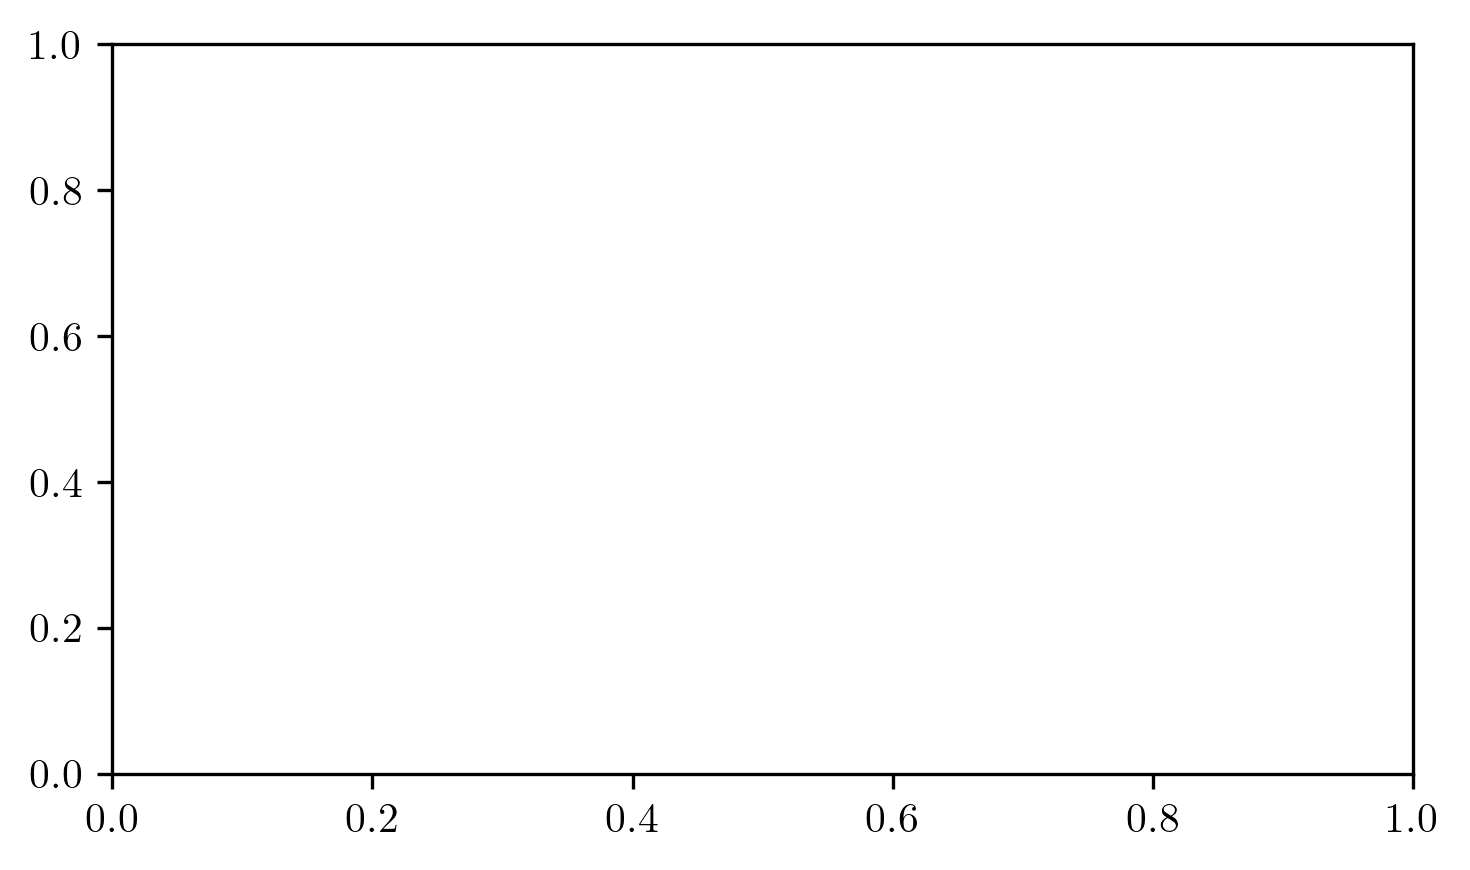

In [3]:
# Enable LaTeX rendering
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

fig, axes = plt.subplots(figsize=(5,3), dpi=300)

object_dfs = [pd.read_json(os.path.join(base_path, f'objects_{name}.json')) for name in models]
line_styles = ['-', 'dashed', '-', '-']

key = 'wofscast_vs_wofs'

for i in range(len(object_dfs)):
    label = display_name.get(models[i], models[i])
    pod_label = f'{label} POD'
    sr_label = f'{label} SR'
    csi_label = f'{label} CSI'
    fb_label = f'{label} FB'
    
    lw = 1.75
        
    
    ax.plot(times, object_dfs[i][f'{key}_POD'], c='xkcd:tomato red', label=pod_label, ls=line_styles[i], lw=lw, alpha=0.9)
    ax.plot(times, object_dfs[i][f'{key}_SR'], c='xkcd:deep blue', label=sr_label, ls=line_styles[i], lw=lw, alpha=0.9)
    ax.plot(times, object_dfs[i][f'{key}_CSI'], c='black', label=csi_label, ls=line_styles[i], lw=lw, alpha=0.8)
    ax.plot(times, object_dfs[i][f'{key}_FB'], c='xkcd:bluish purple', label=fb_label, ls=line_styles[i], lw=lw, alpha=0.8)

    # Add the labels next to the lines
    ax.text(times[-1], object_dfs[i][f'{key}_POD'].iloc[-1], 'POD', color='xkcd:tomato red', 
            fontsize=10, va='center')
    ax.text(times[-1], object_dfs[i][f'{key}_SR'].iloc[-1], 'SR', color='xkcd:deep blue', 
            fontsize=10, va='center')
    ax.text(times[-1], object_dfs[i][f'{key}_CSI'].iloc[-1], 'CSI', color='black', 
            fontsize=10, va='center')
    ax.text(times[-1], object_dfs[i][f'{key}_FB'].iloc[-1], 'FB', color='xkcd:bluish purple', 
            fontsize=10, va='center')
    
    
ax.set(xlabel= 'Forecast Lead Time (mins)', 
       ylabel= f"Score", 
       title = 'Matching WoFS-Cast Storms with WoFS Storms'
      )

ax.grid(ls='dashed', alpha=0.8)
# Hide the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
    
ax.set_ylim([0,1.0])
    

    
    
    
plt.tight_layout()


## WoFSCast & WoFS vs. MRMS Time Series of POD, SR, CSI 

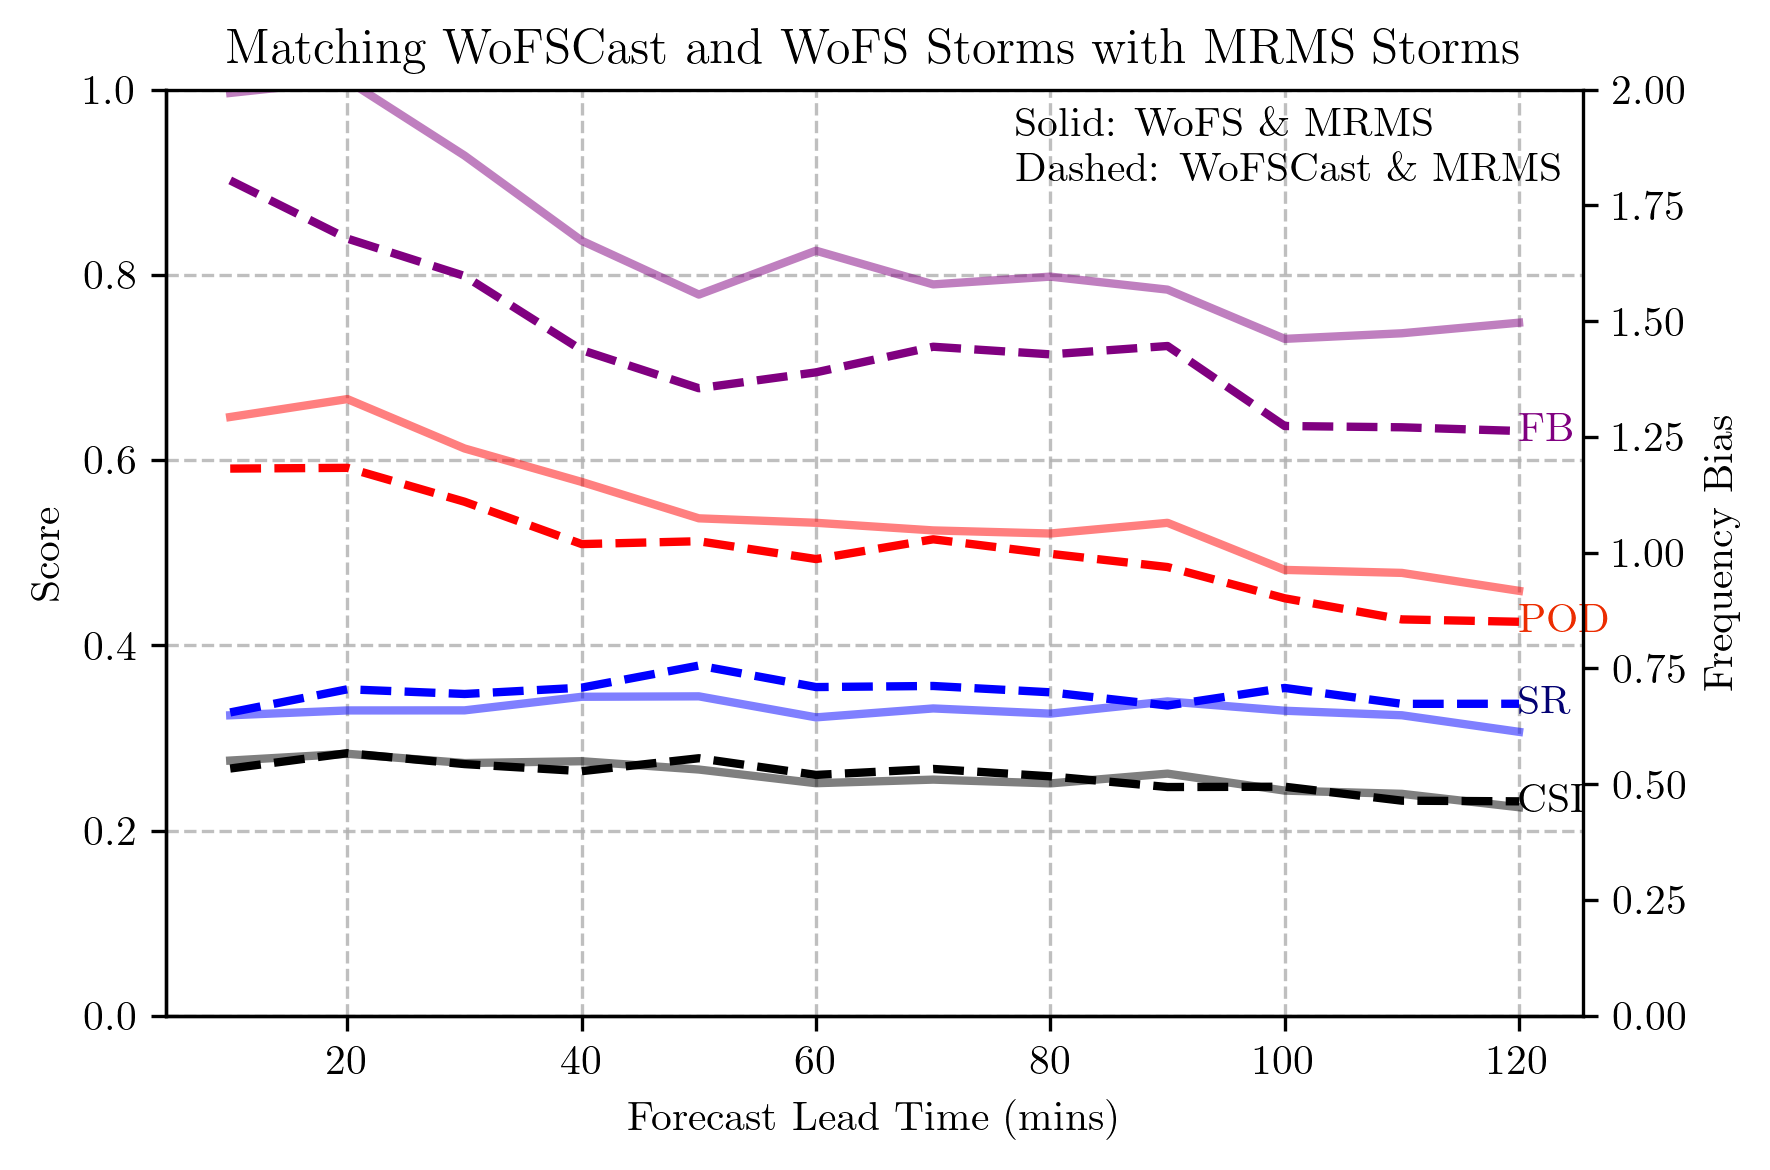

In [4]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=300)

ax_twin = ax.twinx()

object_df = pd.read_json(os.path.join(base_path, 'objects_wofscast_test_v203.json'))

#object_df = pd.read_json(os.path.join(base_path, 'objects_wofscast_best_10min_model.json'))

keys = ['wofscast_vs_mrms', 'wofs_vs_mrms']
line_styles = ['dashed', '-']

# Define the base list of colors
base_colors = ['#FF6347', '#1E90FF', '#32CD32', '#8A2BE2']  # Tomato Red, Dodger Blue, Lime Green, Blue Violet

# Function to lighten a color
def lighten_color(color, amount=0.5):
    try:
        c = mcolors.cnames[color]
    except:
        c = color
    c = mcolors.ColorConverter().to_rgb(c)
    return mcolors.to_hex([min(1, 1 - (1 - x) * (1 - amount)) for x in c])

# Create the lighter version of the base colors
lighter_colors = [lighten_color(c, 0.5) for c in base_colors]

data = {} 

for i, key in enumerate(keys):
    pod_label = f'{key} POD'
    sr_label = f'{key} SR'
    csi_label = f'{key} CSI'
    fb_label = f'{key} FB'
    
    # Plot the lines
    lw = 2.0
    
    # Using the formulas from Brooks 2004 paper on signal theory 
    # a+b+c+d = 1.0 
    # f = a + c (assumed base rate)
    # a = f*POD
    # b = a*(FAR/SR)
    
    f = 0.1
    pod = object_df[f'{key}_POD'].values
    sr = object_df[f'{key}_SR'].values
    far = 1.0-sr
    
    a = f*pod 
    b = a*(far/sr)
    d = 1-f-b
    c = 1-f-d
    
    # POD Skill = (ad-bc) / (x_bar * (1-f))
    # SR Skill = (ad-bc) / (f * (1-x_bar))
    
    x_bar = 0.5
    
    pod_skill = (a*d-b*c) / (x_bar * (1.0-f))
    sr_skill = (a*d-b*c) / (f * (1.0-x_bar))
    
    
    data[f'{key} POD'] = object_df[f'{key}_POD']
    data[f'{key} SR'] = object_df[f'{key}_SR']
    
    pod_line, = ax.plot(times, object_df[f'{key}_POD'], c='red', label=pod_label, ls=line_styles[i], 
                        lw=lw, alpha=1.0-(i*0.5))
    sr_line, = ax.plot(times, object_df[f'{key}_SR'], c='blue', label=sr_label, ls=line_styles[i], 
                       lw=lw, alpha=1.0-(i*0.5))
    csi_line, = ax.plot(times, object_df[f'{key}_CSI'], c='black', label=csi_label, ls=line_styles[i], 
                        lw=lw, alpha=1.0-(i*0.5))
    fb_line, = ax_twin.plot(times, object_df[f'{key}_FB'], c='purple', label=fb_label, ls=line_styles[i], 
                       lw=lw, alpha=1.0-(i*0.5))
    
    
    #line, = ax.plot(times, pod_skill, c='purple', label='POD Skill', ls=line_styles[i], 
    #                   lw=lw, alpha=1.0-(i*0.5))
    #line, = ax.plot(times, sr_skill, c='blue', label='POD Skill', ls=line_styles[i], 
    #                   lw=lw, alpha=1.0-(i*0.5))
    
    subkey = key.split('_vs_')[0].capitalize()
    
    # Add the labels next to the lines
    if i==0:
 
        ax.text(times[-1], object_df[f'{key}_POD'].iloc[-1], 'POD', color='xkcd:tomato red', 
            fontsize=10, va='center')
        ax.text(times[-1], object_df[f'{key}_SR'].iloc[-1], 'SR', color='xkcd:deep blue', 
            fontsize=10, va='center')
        ax.text(times[-1], object_df[f'{key}_CSI'].iloc[-1], 'CSI', color='black', 
            fontsize=10, va='center')
        ax_twin.text(times[-1], object_df[f'{key}_FB'].iloc[-1], 'FB', color='purple', 
            fontsize=10, va='center')

        #ax.text(times[-1], pod_skill[-1], 'POD Skill', color='purple', 
        #    fontsize=10, va='center')
        #ax.text(times[-1], sr_skill[-1], 'SR Skill', color='blue', 
        #    fontsize=10, va='center')
        
        
        
ax.set(xlabel='Forecast Lead Time (mins)', 
       ylabel="Score", 
       title='Matching WoFSCast and WoFS Storms with MRMS Storms'
      )


ax.annotate('Solid: WoFS \& MRMS', xy=(0.6, 0.95), xycoords='axes fraction')
ax.annotate('Dashed: WoFSCast \& MRMS', xy=(0.6, 0.9), xycoords='axes fraction')

ax.grid(ls='dashed', alpha=0.8)
# Hide the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_ylim([0, 1.0])
ax_twin.set_ylim([0, 2.])
ax_twin.set_ylabel('Frequency Bias')

plt.tight_layout()
# plt.savefig(f"figures/ObjectsVerify_{os.path.basename(MODEL_PATH).replace('.npz','')}.png")
plt.show()


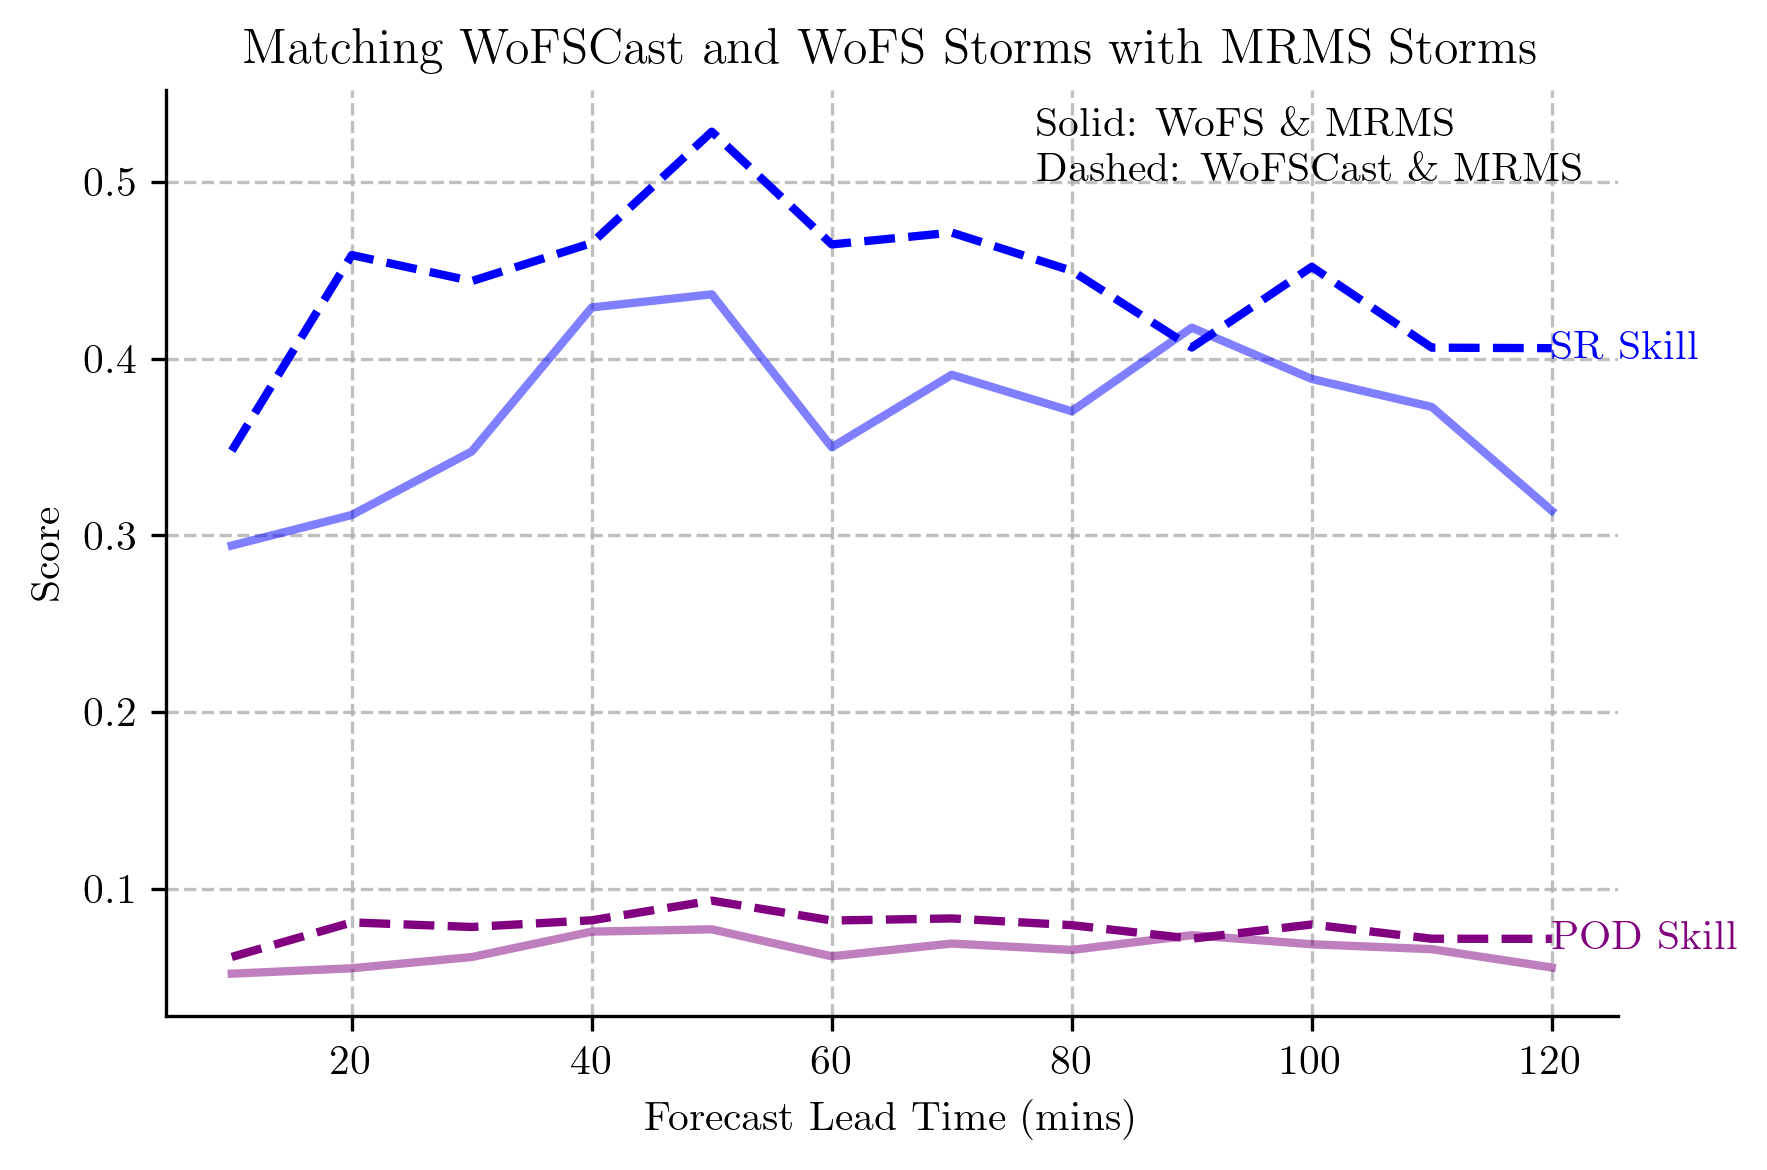

In [5]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import os

fig, ax = plt.subplots(figsize=(6, 4), dpi=300)

object_df = pd.read_json(os.path.join(base_path, 'objects_wofscast_test_v203.json'))

keys = ['wofscast_vs_mrms', 'wofs_vs_mrms']
line_styles = ['dashed', '-']

# Define the base list of colors
base_colors = ['#FF6347', '#1E90FF', '#32CD32', '#8A2BE2']  # Tomato Red, Dodger Blue, Lime Green, Blue Violet

# Function to lighten a color
def lighten_color(color, amount=0.5):
    try:
        c = mcolors.cnames[color]
    except:
        c = color
    c = mcolors.ColorConverter().to_rgb(c)
    return mcolors.to_hex([min(1, 1 - (1 - x) * (1 - amount)) for x in c])

# Create the lighter version of the base colors
lighter_colors = [lighten_color(c, 0.5) for c in base_colors]


for i, key in enumerate(keys):
    pod_label = f'{key} POD'
    sr_label = f'{key} SR'
    csi_label = f'{key} CSI'
    fb_label = f'{key} FB'
    
    # Plot the lines
    lw = 2.0
    
    # Using the formulas from Brooks 2004 paper on signal theory 
    # a+b+c+d = 1.0 
    # f = a + c (assumed base rate)
    # a = f*POD
    # b = a*(FAR/SR)
    
    f = 0.15
    pod = object_df[f'{key}_POD'].values
    sr = object_df[f'{key}_SR'].values
    far = 1.0-sr
    
    a = f*pod 
    b = a*(far/sr)
    d = 1-f-b
    c = 1-f-d
    
    # POD Skill = (ad-bc) / (x_bar * (1-f))
    # SR Skill = (ad-bc) / (f * (1-x_bar))
    
    x_bar = 0.5
    
    pod_skill = (a*d-b*c) / (x_bar * (1.0-f))
    sr_skill = (a*d-b*c) / (f * (1.0-x_bar))
    
    csi = object_df[f'{key}_CSI']
    ncsi = (csi - f) / 1-f    
    
    line, = ax.plot(times, pod_skill, c='purple', label='POD Skill', ls=line_styles[i], 
                       lw=lw, alpha=1.0-(i*0.5))
    line, = ax.plot(times, sr_skill, c='blue', label='POD Skill', ls=line_styles[i], 
                       lw=lw, alpha=1.0-(i*0.5))
    #line, = ax.plot(times, ncsi, c='blue', label='POD Skill', ls=line_styles[i], 
    #                   lw=lw, alpha=1.0-(i*0.5))
    
    subkey = key.split('_vs_')[0].capitalize()
    
    # Add the labels next to the lines
    if i==0:
        ax.text(times[-1], pod_skill[-1], 'POD Skill', color='purple', 
            fontsize=10, va='center')
        ax.text(times[-1], sr_skill[-1], 'SR Skill', color='blue', 
            fontsize=10, va='center')
        
        
        
ax.set(xlabel='Forecast Lead Time (mins)', 
       ylabel="Score", 
       title='Matching WoFSCast and WoFS Storms with MRMS Storms'
      )


ax.annotate('Solid: WoFS \& MRMS', xy=(0.6, 0.95), xycoords='axes fraction')
ax.annotate('Dashed: WoFSCast \& MRMS', xy=(0.6, 0.9), xycoords='axes fraction')

ax.grid(ls='dashed', alpha=0.8)
# Hide the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#ax.set_ylim([0, 1.0])

plt.tight_layout()
# plt.savefig(f"figures/ObjectsVerify_{os.path.basename(MODEL_PATH).replace('.npz','')}.png")
plt.show()


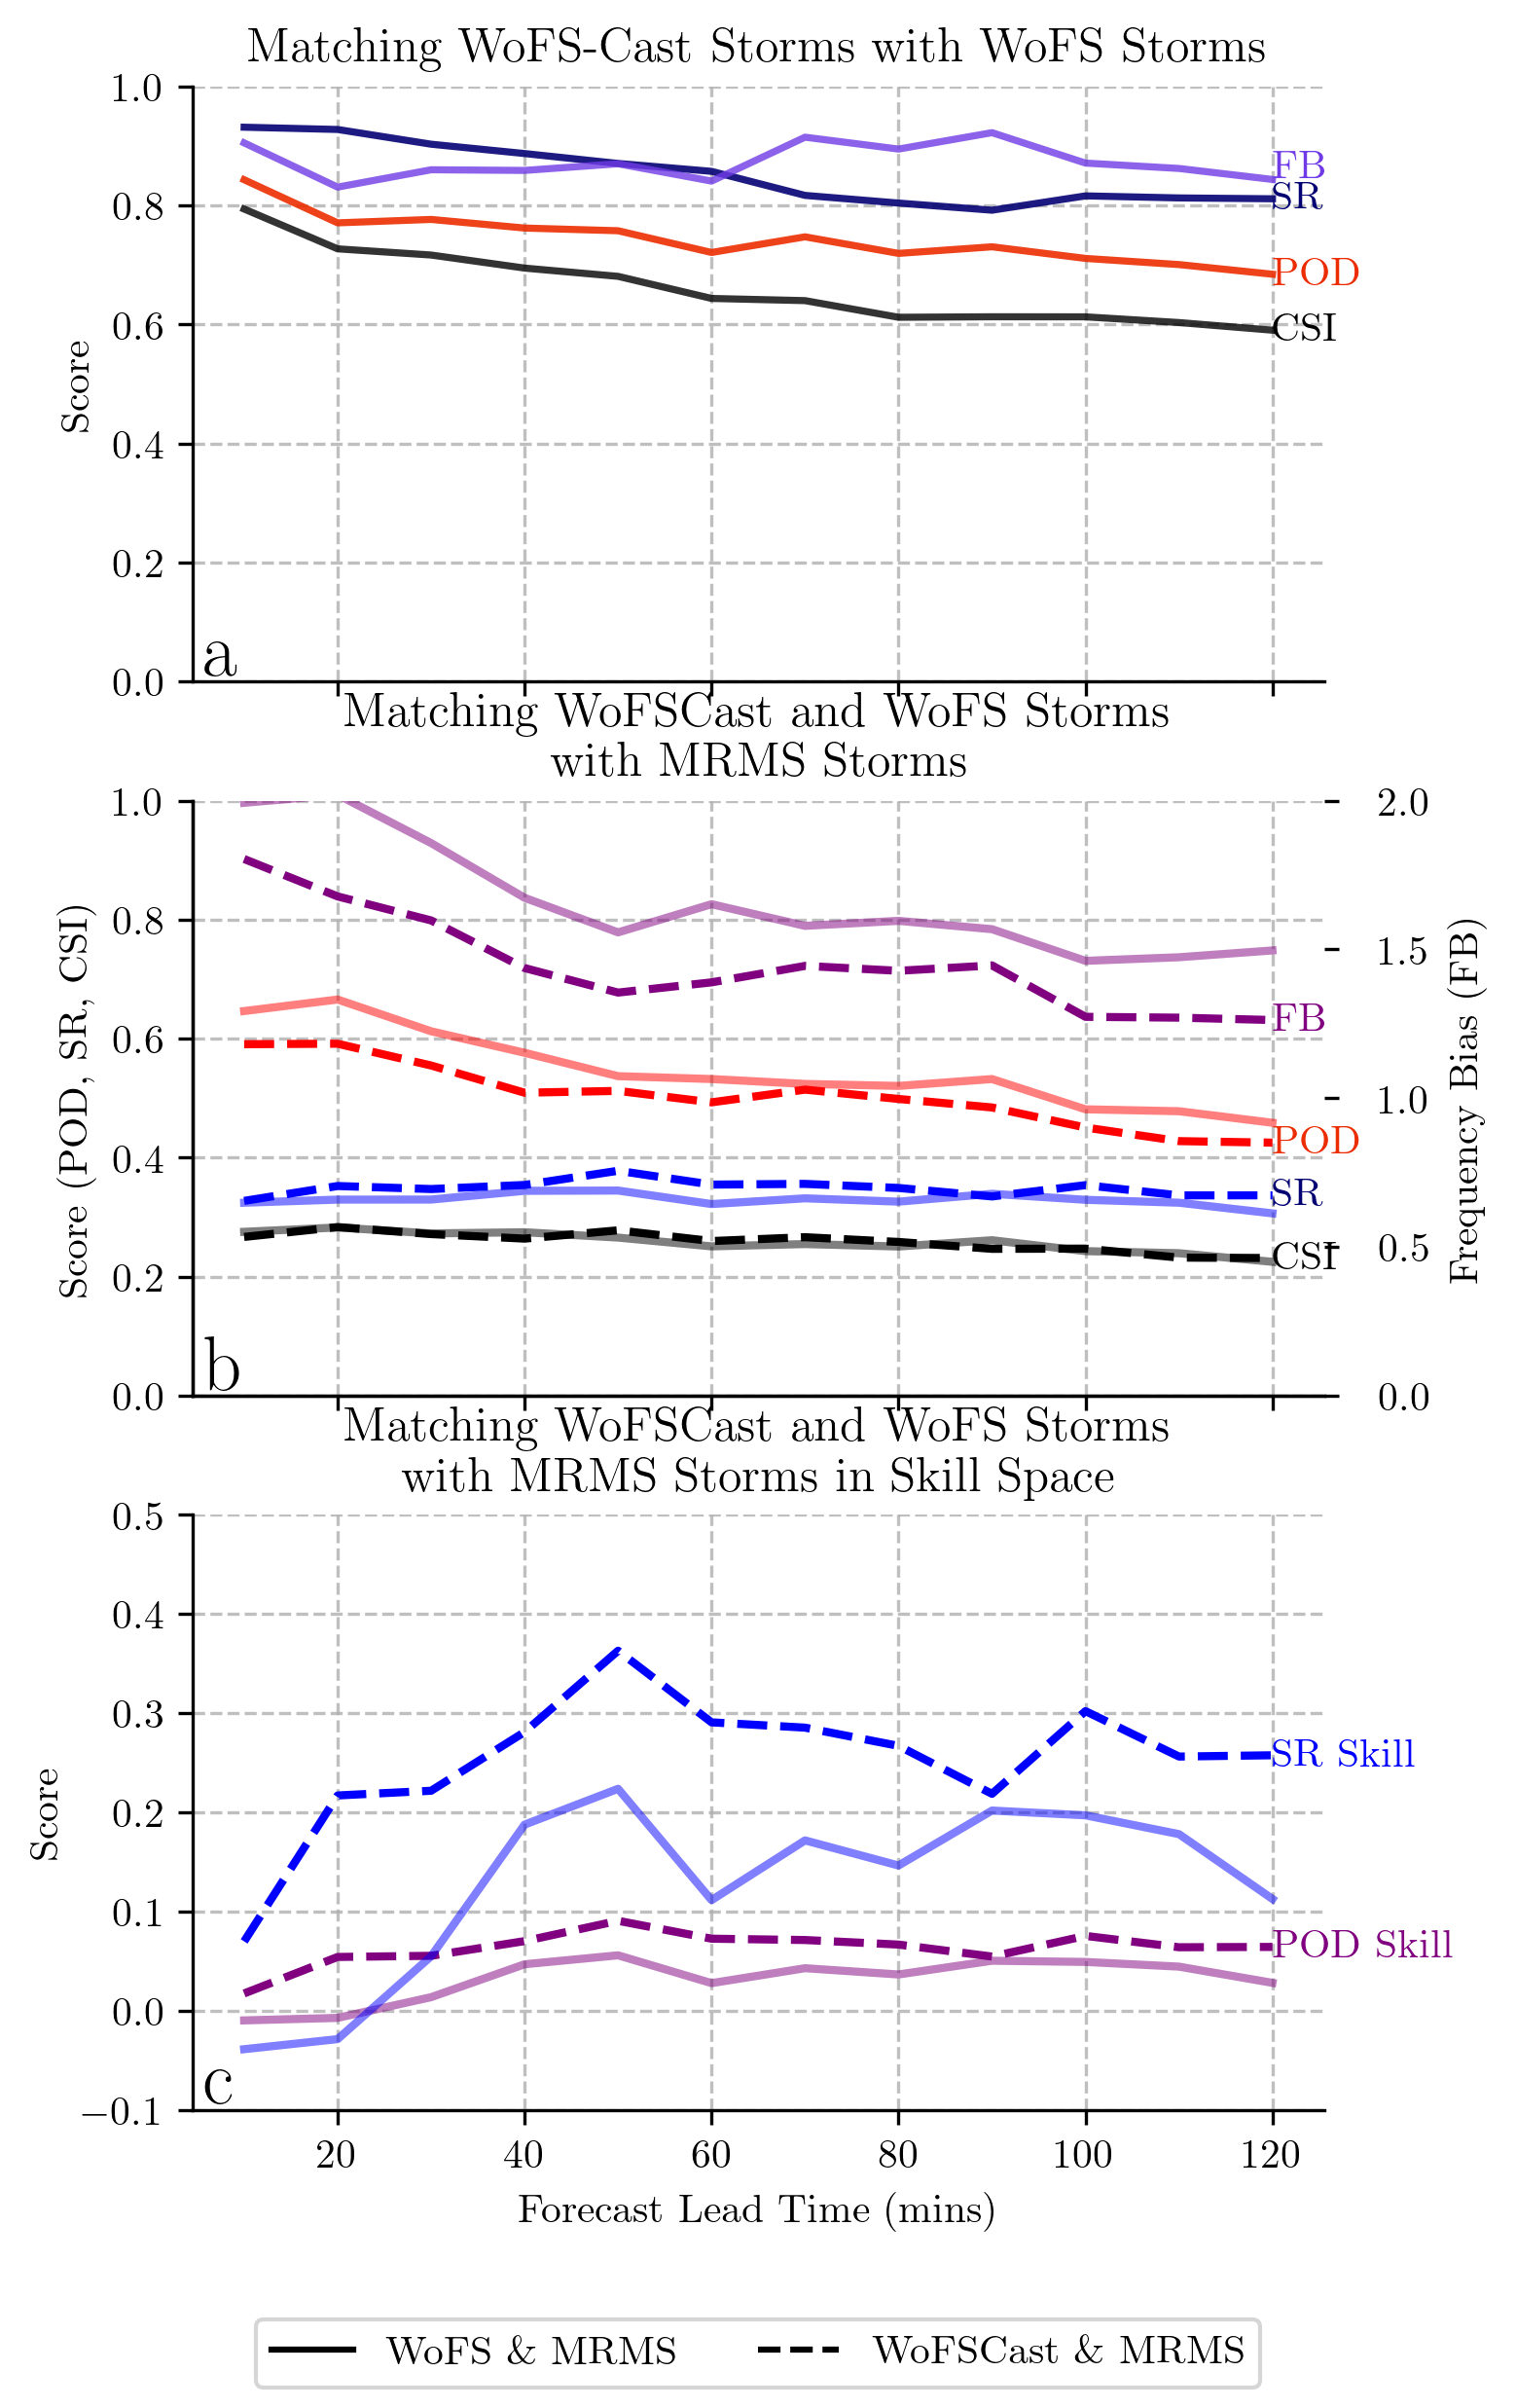

In [7]:
# Enable LaTeX rendering
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

import matplotlib.lines as mlines

fig, axes = plt.subplots(figsize=(5,3*3), dpi=300, nrows=3, sharex=True)

models = ['wofscast_test_v203'] 

object_dfs = [pd.read_json(os.path.join(base_path, f'objects_{name}.json')) for name in models]
object_df = pd.read_json(os.path.join(base_path, 'objects_wofscast_test_v203.json'))

line_styles = ['-', 'dashed', '-', '-']

key = 'wofscast_vs_wofs'

ax = axes[0]
ax.annotate('a', xy=(0.01, 0.01), xycoords='axes fraction', fontsize=19)

for i in range(len(object_dfs)):
    label = display_name.get(models[i], models[i])
    pod_label = f'{label} POD'
    sr_label = f'{label} SR'
    csi_label = f'{label} CSI'
    fb_label = f'{label} FB'
    
    lw = 1.75
        
    
    ax.plot(times, object_dfs[i][f'{key}_POD'], c='xkcd:tomato red', 
            label=pod_label, ls=line_styles[i], lw=lw, alpha=0.9)
    ax.plot(times, object_dfs[i][f'{key}_SR'], c='xkcd:deep blue', 
            label=sr_label, ls=line_styles[i], lw=lw, alpha=0.9)
    ax.plot(times, object_dfs[i][f'{key}_CSI'], c='black', 
            label=csi_label, ls=line_styles[i], lw=lw, alpha=0.8)
    ax.plot(times, object_dfs[i][f'{key}_FB'], c='xkcd:bluish purple', 
            label=fb_label, ls=line_styles[i], lw=lw, alpha=0.8)

    # Add the labels next to the lines
    ax.text(times[-1], object_dfs[i][f'{key}_POD'].iloc[-1], 'POD', color='xkcd:tomato red', 
            fontsize=10, va='center')
    ax.text(times[-1], object_dfs[i][f'{key}_SR'].iloc[-1], 'SR', color='xkcd:deep blue', 
            fontsize=10, va='center')
    ax.text(times[-1], object_dfs[i][f'{key}_CSI'].iloc[-1], 'CSI', color='black', 
            fontsize=10, va='center')
    ax.text(times[-1], object_dfs[i][f'{key}_FB'].iloc[-1]+0.02, 'FB', color='xkcd:bluish purple', 
            fontsize=10, va='center')
    
    
ax.set(
       #xlabel= 'Forecast Lead Time (mins)', 
       ylabel= f"Score", 
       title = 'Matching WoFS-Cast Storms with WoFS Storms'
      )

ax.grid(ls='dashed', alpha=0.8)
# Hide the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
    
ax.set_ylim([0,1.0])
    
ax = axes[1]
ax.annotate('b', xy=(0.01, 0.01), xycoords='axes fraction', fontsize=19)

ax_twin = ax.twinx()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

object_df = pd.read_json(os.path.join(base_path, 'objects_wofscast_test_v203.json'))

keys = ['wofscast_vs_mrms', 'wofs_vs_mrms']
line_styles = ['dashed', '-']

# Define the base list of colors
base_colors = ['#FF6347', '#1E90FF', '#32CD32', '#8A2BE2']  
# Tomato Red, Dodger Blue, Lime Green, Blue Violet

# Function to lighten a color
def lighten_color(color, amount=0.5):
    try:
        c = mcolors.cnames[color]
    except:
        c = color
    c = mcolors.ColorConverter().to_rgb(c)
    return mcolors.to_hex([min(1, 1 - (1 - x) * (1 - amount)) for x in c])

# Create the lighter version of the base colors
lighter_colors = [lighten_color(c, 0.5) for c in base_colors]

data = {} 

for i, key in enumerate(keys):
    pod_label = f'{key} POD'
    sr_label = f'{key} SR'
    csi_label = f'{key} CSI'
    fb_label = f'{key} FB'
    
    # Plot the lines
    lw = 2.0
    
    # Using the formulas from Brooks 2004 paper on signal theory 
    # a+b+c+d = 1.0 
    # f = a + c (assumed base rate)
    # a = f*POD
    # b = a*(FAR/SR)
    
    f = 0.1
    pod = object_df[f'{key}_POD'].values
    sr = object_df[f'{key}_SR'].values
    far = 1.0-sr
    
    a = f*pod 
    b = a*(far/sr)
    d = 1-f-b
    c = 1-f-d
    
    # POD Skill = (ad-bc) / (x_bar * (1-f))
    # SR Skill = (ad-bc) / (f * (1-x_bar))
    
    x_bar = 0.5
    
    pod_skill = (a*d-b*c) / (x_bar * (1.0-f))
    sr_skill = (a*d-b*c) / (f * (1.0-x_bar))
    
    
    data[f'{key} POD'] = object_df[f'{key}_POD']
    data[f'{key} SR'] = object_df[f'{key}_SR']
    
    pod_line, = ax.plot(times, object_df[f'{key}_POD'], c='red', label=pod_label, ls=line_styles[i], 
                        lw=lw, alpha=1.0-(i*0.5))
    sr_line, = ax.plot(times, object_df[f'{key}_SR'], c='blue', label=sr_label, ls=line_styles[i], 
                       lw=lw, alpha=1.0-(i*0.5))
    csi_line, = ax.plot(times, object_df[f'{key}_CSI'], c='black', label=csi_label, ls=line_styles[i], 
                        lw=lw, alpha=1.0-(i*0.5))
    fb_line, = ax_twin.plot(times, object_df[f'{key}_FB'], c='purple', label=fb_label, ls=line_styles[i], 
                       lw=lw, alpha=1.0-(i*0.5))
    
    
    #line, = ax.plot(times, pod_skill, c='purple', label='POD Skill', ls=line_styles[i], 
    #                   lw=lw, alpha=1.0-(i*0.5))
    #line, = ax.plot(times, sr_skill, c='blue', label='POD Skill', ls=line_styles[i], 
    #                   lw=lw, alpha=1.0-(i*0.5))
    
    subkey = key.split('_vs_')[0].capitalize()
    
    # Add the labels next to the lines
    if i==0:
 
        ax.text(times[-1], object_df[f'{key}_POD'].iloc[-1], 'POD', color='xkcd:tomato red', 
            fontsize=10, va='center')
        ax.text(times[-1], object_df[f'{key}_SR'].iloc[-1], 'SR', color='xkcd:deep blue', 
            fontsize=10, va='center')
        ax.text(times[-1], object_df[f'{key}_CSI'].iloc[-1], 'CSI', color='black', 
            fontsize=10, va='center')
        ax_twin.text(times[-1], object_df[f'{key}_FB'].iloc[-1], 'FB', color='purple', 
            fontsize=10, va='center')

        #ax.text(times[-1], pod_skill[-1], 'POD Skill', color='purple', 
        #    fontsize=10, va='center')
        #ax.text(times[-1], sr_skill[-1], 'SR Skill', color='blue', 
        #    fontsize=10, va='center')
        
        
        
ax.set(
       #xlabel='Forecast Lead Time (mins)', 
       ylabel="Score (POD, SR, CSI)", 
       title='Matching WoFSCast and WoFS Storms\nwith MRMS Storms'
      )


#ax.annotate('Solid: WoFS \& MRMS', xy=(0.5, 0.95), xycoords='axes fraction', color = 'gray')
#ax.annotate('Dashed: WoFSCast \& MRMS', xy=(0.5, 0.9), xycoords='axes fraction', color='gray')

ax.grid(ls='dashed', alpha=0.8)
# Hide the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_ylim([0, 1.0])
ax_twin.set_ylim([0, 2.])
# Add padding to y-tick marks
ax_twin.tick_params(axis='y', which='major', pad=10)  # Adjust the pad value as needed
ax_twin.spines['top'].set_visible(False)
ax_twin.spines['right'].set_visible(False)


ax_twin.set_ylabel('Frequency Bias (FB)')


ax = axes[-1]
ax.annotate('c', xy=(0.01, 0.01), xycoords='axes fraction', fontsize=19)

#object_df = pd.read_json(os.path.join(base_path, 'objects_wofscast_test_v203.json'))

keys = ['wofscast_vs_mrms', 'wofs_vs_mrms']
line_styles = ['dashed', '-']

# Define the base list of colors
base_colors = ['#FF6347', '#1E90FF', '#32CD32', '#8A2BE2']  
# Tomato Red, Dodger Blue, Lime Green, Blue Violet

# Function to lighten a color
def lighten_color(color, amount=0.5):
    try:
        c = mcolors.cnames[color]
    except:
        c = color
    c = mcolors.ColorConverter().to_rgb(c)
    return mcolors.to_hex([min(1, 1 - (1 - x) * (1 - amount)) for x in c])

# Create the lighter version of the base colors
lighter_colors = [lighten_color(c, 0.5) for c in base_colors]


for i, key in enumerate(keys):
    pod_label = f'{key} POD'
    sr_label = f'{key} SR'
    csi_label = f'{key} CSI'
    fb_label = f'{key} FB'
    
    # Plot the lines
    lw = 2.0
    
    # Using the formulas from Brooks 2004 paper on signal theory 
    # a+b+c+d = 1.0 
    # f = a + c (assumed base rate)
    # a = f*POD
    # b = a*(FAR/SR)
    
    f = 0.2
    pod = object_df[f'{key}_POD'].values
    sr = object_df[f'{key}_SR'].values
    far = 1.0-sr
    
    a = f*pod 
    b = a*(far/sr)
    d = 1-f-b
    c = 1-f-d
    
    # POD Skill = (ad-bc) / (x_bar * (1-f))
    # SR Skill = (ad-bc) / (f * (1-x_bar))
    
    x_bar = 0.5
    
    pod_skill = (a*d-b*c) / (x_bar * (1.0-f))
    sr_skill = (a*d-b*c) / (f * (1.0-x_bar))
    
    csi = object_df[f'{key}_CSI']
    ncsi = (csi - f) / 1-f    
    
    line, = ax.plot(times, pod_skill, c='purple', label='POD Skill', ls=line_styles[i], 
                       lw=lw, alpha=1.0-(i*0.5))
    line, = ax.plot(times, sr_skill, c='blue', label='POD Skill', ls=line_styles[i], 
                       lw=lw, alpha=1.0-(i*0.5))
    #line, = ax.plot(times, ncsi, c='blue', label='POD Skill', ls=line_styles[i], 
    #                   lw=lw, alpha=1.0-(i*0.5))
    
    subkey = key.split('_vs_')[0].capitalize()
    
    # Add the labels next to the lines
    if i==0:
        ax.text(times[-1], pod_skill[-1], 'POD Skill', color='purple', 
            fontsize=10, va='center')
        ax.text(times[-1], sr_skill[-1], 'SR Skill', color='blue', 
            fontsize=10, va='center')
         
ax.set(
       xlabel='Forecast Lead Time (mins)', 
       ylabel="Score", 
       title='Matching WoFSCast and WoFS Storms\n with MRMS Storms in Skill Space'
      )


#ax.annotate('Solid: WoFS \& MRMS', xy=(0.5, 0.95), xycoords='axes fraction', color = 'gray')
#ax.annotate('Dashed: WoFSCast \& MRMS', xy=(0.5, 0.9), xycoords='axes fraction', color='gray')

ax.grid(ls='dashed', alpha=0.8)
# Hide the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_ylim([-0.1, 0.5])

# Create custom legend handles (lines)
solid_line = mlines.Line2D([], [], color='black', linestyle='-', label="WoFS \& MRMS")
dashed_line = mlines.Line2D([], [], color='black', linestyle='--', label="WoFSCast \& MRMS")
# Add the legend
fig.legend(handles=[solid_line, dashed_line], loc='lower center', ncol=2)


#plt.tight_layout()